In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import sys; sys.path.append('..')
from sgr_tools.ScenarioGeneration.Parametric.Forecast.Models import MARX
from sgr_tools.ScenarioGeneration.Parametric.Forecast.Tools import Splines
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
n = 8760
idx = pd.date_range(start="2020-01-01", periods=n, freq="H")

heat_load = pd.Series(
    sm.tsa.ArmaProcess(
        np.r_[1, -np.random.rand(1)],
        np.r_[1, -np.random.rand(1)],
    ).generate_sample(nsample=n),
    index=idx,
)
solar = pd.Series(
    sm.tsa.ArmaProcess(
        np.r_[1, -np.random.rand(1)],
        np.r_[1, -np.random.rand(1)],
    ).generate_sample(nsample=n),
    index=idx,
)


bs_df = 4
exog = Splines(seasonality=24, degrees_freedom=bs_df).get_fit(idx=heat_load.index)

/var/folders/_0/pycjxcpn11j1k41mjdskw2rc0000gn/T/ipykernel_72304/8174198.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(start="2020-01-01", periods=n, freq="H")


In [3]:
y = pd.DataFrame(
    {
        "Heat load": heat_load,
        "Solar": solar,
    }, index=idx
)

n_train = 168 * 6
n_test = 168 * 1

t_test = y.index[n_train : n_train + n_test]
t_train = y.index[:n_train]

exog_train = exog.loc[t_train, :]
exog_test = exog.loc[t_test, :]

y_train = y.loc[t_train, :]
y_test = y.loc[t_test, :]

marx = MARX()
marx.fit(y_train=y_train, exog_train=exog_train, lags=[1])

In [4]:
n_scen = 5
scenarios = marx.simulate_scenarios(y0=y_train.iloc[-1:,:], exog=exog_test, n_scen=n_scen, t_range=t_test, threads=-1)


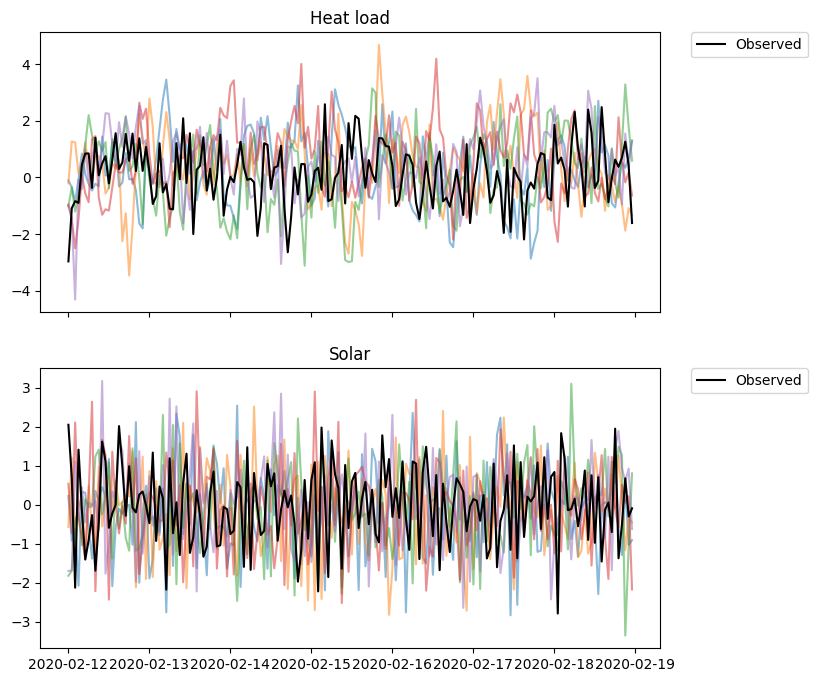

In [ ]:
fig, axs = plt.subplots(nrows=len(y.columns), figsize=(8, 8), sharex=True)
for i, series in enumerate(y.columns):
    axs[i].plot(y_test[series].index, scenarios.data[series], alpha=0.5)
    axs[i].set_title(series)
    axs[i].plot(y_test[series], color='black', label='Observed')
    axs[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)